In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
import os

def euler_method(f, t, y, h):
    return y + h * f(t, y)

def midpoint_method(f, t, y, h):
    K1 = f(t, y)
    K2 = f(t+h*0.5, y+(h*0.5*K1))
    return y + h * K2

def RK4_method(f, t, y, h):
    K1 = f(t, y)
    K2 = f(t+h*0.5, y+(h*0.5*K1))
    K3 = f(t+h*0.5, y+(h*0.5*K2))
    K4 = f(t+h, y+(h*K3))
    return y + h*(K1/6+K2/3+K3/3+K4/6)

In [2]:
def mass_to_radius(m, min_r, max_r):
    if(np.max(m) == np.min(m)):
        r = np.ones_like(m)*max_r
    else:
        r = (m-np.min(m))*((max_r-min_r)/(np.max(m)-np.min(m)))+min_r
    return r.astype(int)

def y_to_pos(y,l,shape,pos_start):
    pos = []
    pos.append(pos_start)
    for i in range(len(y)):
        theta = y[i, 0]
        pos.append((
                pos[i][0]+int(l[i]*np.sin(theta)),
                pos[i][1]+int(l[i]*np.cos(theta))
            ))
    return pos

def render_frame(y, y_prev, l, r, canvas, meter_scale=1, trace_factor=0.99):
    shape = canvas.shape
    canvas[:] = canvas*[trace_factor,trace_factor,trace_factor]
    y_b = y[1:]
        
    pos_block = (shape[0]//2+int(y[0,0]*meter_scale), shape[0]//2)
    pos_block_prev = (shape[0]//2+int(y_prev[0,0]*meter_scale), shape[0]//2)
    pos = y_to_pos(y_b, l, shape, pos_block)
    pos_prev = y_to_pos(y_prev[1:], l, shape,pos_block_prev)
        
    # traces
    for i in range(len(y_b)):
        cv2.line(canvas, pos_prev[i+1], pos[i+1], [int(180-180*(float(i)/len(y_b))),64,int(180*(float(i)/len(y_b)))], 2)
    img = canvas.copy()
    
    cv2.line(img, (shape[0]//2, shape[0]//2-12), (shape[0]//2, shape[0]//2+12), [0,0,128], 2)

    cv2.rectangle(img, (pos_block[0]-12,pos_block[1]-6), (pos_block[0]+12,pos_block[1]+6), [235,240,245], -1)

    # lines
    for i in range(len(y_b)):
        cv2.line(img, pos[i], pos[i+1], [64,64,64], 2)
    # balls
    for i in range(len(y_b)):
        cv2.circle(img, pos[i+1], r[i], [int(255-255*(float(i)/len(y_b))),32,int(255*(float(i)/len(y_b)))], -1)
        cv2.circle(img, (pos[i+1][0]+r[i]//3,pos[i+1][1]-r[i]//3), r[i]//3, [235,240,245], -1)
        pos_last = pos
    
    return img

def balls_animation(t, y, l, m, size, trace_factor, pre=''):
    path = 'output/'+pre+'_'+str(time.time())+'.avi'
    if(int(cv2.__version__.split('.')[0]) < 3):
        fourcc = cv2.cv.CV_FOURCC(*'MJPG')
    else:
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    video = cv2.VideoWriter(path, fourcc, len(t)//t[-1], (size,size))
    
    canvas = np.zeros((size,size,3))
    
    meter_scale = ((0.4 * size)/np.sum(l))
    l_scaled = l * meter_scale
    m_scaled = mass_to_radius(m, 6, 12)
    for i in range(len(t)):
        if i>0:
            y_prev = y[i-1]
        else:
            y_prev = y[i]
        frame = render_frame(y[i], y_prev, l_scaled, m_scaled, canvas, meter_scale=meter_scale, trace_factor=trace_factor)
        video.write(frame.astype(np.uint8))
    video.release()
    
    path_mp4 = path[:-4]+'.mp4'
    os.popen("ffmpeg -i '{input}' -ac 2 -b:v 2000k -c:a aac -c:v libx264 -b:a 160k -vprofile high -bf 0 -strict experimental -f mp4 '{path_mp4}'".format(input = path, path_mp4=path_mp4))
    os.remove(path)
    return path_mp4

In [12]:
from sympy import diff, symbols, cos, sin, Derivative, solve, Symbol, expand

def euler_lagrange(lagrangian, t, x_dx_ddx):
    equations = []
    for syms in x_dx_ddx:
        x,dx,ddx = syms
        dlag_x = diff(lagrangian, x)
        dlag_dx = diff(lagrangian, dx)
        for syms2 in x_dx_ddx:
            x2,dx2,ddx2 = syms2
            dlag_dx = dlag_dx.subs([(dx2, Derivative(x2(t), t)), (x2, x2(t))])
        dlag_dx_t = diff(dlag_dx, t)
        for syms2 in x_dx_ddx:
            x2,dx2,ddx2 = syms2
            dlag_dx_t = dlag_dx_t.subs([
                    (Derivative(x2(t), t, t), ddx2),
                    (Derivative(x2(t), t), dx2),
                    (x2(t), x2)])
        equations.append(dlag_dx_t-dlag_x)
    return equations

In [17]:
N = 1
t = symbols('t')
syms = [ symbols('x dx ddx') ]
x, dx, ddx = syms[0]
syms += [ symbols('th[%d] dth[%d] ddth[%d]'%(i,i,i)) for i in range(N) ]

lagrangian = 0
h = 0
velocity = [dx, 0]
# E_potential spring
# lagrangian -= 0.5*Symbol('k')*x**2
# E_kinetic spring
lagrangian += 0.5*Symbol('m_s')*dx**2
for i in range(N):
    th, dth, ddth = syms[i+1]
    # E_potential ball_i
    h += (Symbol('l[%d]'%(i,))-Symbol('l[%d]'%(i,))*cos(th))
    lagrangian -= Symbol('m[%d]'%(i,))*Symbol('g')*h
    # E_kinetic ball_i
    velocity[0] += Symbol('l[%d]'%(i,))*dth*cos(th)
    velocity[1] += Symbol('l[%d]'%(i,))*dth*sin(th)
    lagrangian += 0.5*Symbol('m[%d]'%(i,))*(velocity[0]**2+velocity[1]**2)


equations = euler_lagrange(lagrangian,t,syms)
ddxs = [ syms[i][2] for i in range(N+1) ]
functions = solve(equations, ddxs)

print simplify(functions)

{ddx: m[0]*(dth[0]**2*l[0] + g*cos(th[0]))*sin(th[0])/(m[0]*sin(th[0])**2 + m_s), ddth[0]: -(dth[0]**2*l[0]*m[0]*cos(th[0]) + g*(m[0] + m_s))*sin(th[0])/(l[0]*(m[0]*sin(th[0])**2 + m_s))}


In [5]:
with open('output/force_t7_%d.py'%(N,), 'w') as fd:
    fd.write('from numpy import sin, cos, zeros_like\n')
    fd.write('def force(g, l, m, k, m_s):\n')
    fd.write('    def f(t, y):\n')
    fd.write('        values = zeros_like(y)\n')
    f = functions
    for i in range(N+1):
        th, dth, ddth = syms[i]
        for j in range(N+1):
            _, _, ddthj = syms[j]
            f[ddthj] = f[ddthj].subs([(th,Symbol('y[%d,0]'%(i,))),(dth,Symbol('y[%d,1]'%(i,)))])
    for i in range(N+1):
        _, _, ddthi = syms[i]
        fd.write('        values[%d,0] = y[%d,1]\n'%(i,i))
        fd.write('        values[%d,1] = '%(i,)+str(f[ddthi])+'\n')
    fd.write('        return values\n')
    fd.write('    return f\n')

In [6]:
from output.force_t7_1 import force
N = 1
g = 9.80665
l = np.array([1 for i in range(N)])
m = np.array([1 for i in range(N)])

k = 1
m_s = 1

f = force(g,l,m,k,m_s)

# Initial state
y0 = np.array([
        [0,0],
        [1.57,0]
    ])

t0 = 0.0
t, y = solve_vec_interactive(RK4_method, f, y0, t0)

In [ ]:
def solve_vec_interactive(method, f, y0, t):
    while
    y = np.zeros((len(t), )+y0.shape, np.float64)
    y[0] = y0
    
    for ti in range(1, len(t)):
        y[ti] = method(f, t[ti-1], y[ti-1], h)
    return t, y

In [ ]:
path = balls_animation(t, y, l, m, 800, 0.995, pre='t6')

HTML('<video width="800" height="800" controls><source src="'+path+'" type="video/mp4"></video>')

In [18]:
def mass_to_radius(m, min_r, max_r):
    if(np.max(m) == np.min(m)):
        r = np.ones_like(m)*max_r
    else:
        r = (m-np.min(m))*((max_r-min_r)/(np.max(m)-np.min(m)))+min_r
    return r.astype(int)

def y_to_pos(y,l,shape,pos_start):
    pos = []
    pos.append(pos_start)
    for i in range(len(y)):
        theta = y[i, 0]
        pos.append((
                pos[i][0]+int(l[i]*np.sin(theta)),
                pos[i][1]+int(l[i]*np.cos(theta))
            ))
    return pos

def render_frame(y, l, r, size, meter_scale=1):
    shape = (size,size,3)
    img = np.zeros(shape)
    
    y_b = y[1:]
        
    pos_block = (shape[0]//2+int(y[0,0]*meter_scale), shape[0]//2)
    pos = y_to_pos(y_b, l, shape, pos_block)

    cv2.rectangle(img, (pos_block[0]-12,pos_block[1]-6), (pos_block[0]+12,pos_block[1]+6), [235,240,245], -1)

    # lines
    for i in range(len(y_b)):
        cv2.line(img, pos[i], pos[i+1], [64,64,64], 2)
    # balls
    for i in range(len(y_b)):
        cv2.circle(img, pos[i+1], r[i], [int(255-255*(float(i)/len(y_b))),32,int(255*(float(i)/len(y_b)))], -1)
        cv2.circle(img, (pos[i+1][0]+r[i]//3,pos[i+1][1]-r[i]//3), r[i]//3, [235,240,245], -1)
        pos_last = pos
    
    return img

def balls_animation(t, y, l, m, size, trace_factor, pre=''):

    
    meter_scale = ((0.4 * size)/np.sum(l))
    l_scaled = l * meter_scale
    m_scaled = mass_to_radius(m, 6, 12)
    for i in range(len(t)):
        if i>0:
            y_prev = y[i-1]
        else:
            y_prev = y[i]
        frame = render_frame(y[i], y_prev, l_scaled, m_scaled, canvas, meter_scale=meter_scale, trace_factor=trace_factor)
        video.write(frame.astype(np.uint8))
    video.release()
    
    path_mp4 = path[:-4]+'.mp4'
    os.popen("ffmpeg -i '{input}' -ac 2 -b:v 2000k -c:a aac -c:v libx264 -b:a 160k -vprofile high -bf 0 -strict experimental -f mp4 '{path_mp4}'".format(input = path, path_mp4=path_mp4))
    os.remove(path)
    return path_mp4

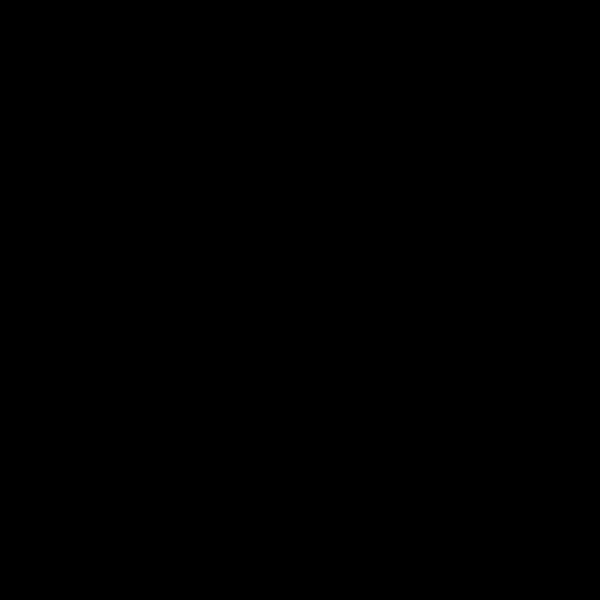

In [20]:
from io import BytesIO
from IPython.display import Image
from ipywidgets import interactive, fixed
import matplotlib.image as mplimg

def display_image(img):
    if img.ndim == 3:
        format, cmap = 'png', None
    else:
        raise NotImplementedError("Only 3-d arrays can be displayed as images.")
    img_rgb = cv2.merge(cv2.split(img)[::-1])
    with BytesIO() as buffer:
        mplimg.imsave(buffer, img_rgb, format=format, cmap=cmap, vmin=0, vmax=255)
        out = buffer.getvalue()
    return Image(out)

#def display_light_field_control(image, color=0.5):
#    output_img = (image*[1,1,color]).astype(np.uint8)
#    return display_image(output_img)
frame_size = 600

t0 = time.time()
y0 = np.array([[0,0], [1.57,0]])

meter_scale = ((0.4 * frame_size)/np.sum(l))
l_scaled = l * meter_scale
m_scaled = mass_to_radius(m, 6, 12)

def solve_vec_interactive(method, f, color=0):
    t = time.time()
    h = t - t0
    y = method(f, t0, y0, h)
    frame = render_frame(y, l_scaled, m_scaled, frame_size, meter_scale=meter_scale)
    return display_image(frame)

color_lims = (0., 1., 0.1)
interactive(solve_vec_interactive, method=fixed(RK4_method), f=fixed(f), color=color_lims)